In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
from torch import Tensor
import torch.optim as optim


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
import scipy.io

torch.set_default_dtype(torch.float)

# Random number generators in other libraries
np.random.seed(28)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 

cpu


In [ ]:
# Lucas/this_script.py
import sys
import os
current_dir = os.getcwd()
print(current_dir)
# Add the 'functions' folder to the Python path
functions_dir = os.path.join(current_dir,'..', 'functions')
sys.path.append(functions_dir)
functions_dir = os.path.join(current_dir,'..', 'Mads')
sys.path.append(functions_dir)

# Now you can import the function
from Load_data import custom_csv_parser2, custom_csv_parser
from Load_data import data_split

pde_keys = ['D1', 'D2', 'I_sc','I_p', 'I_eff', 'G', 'G_sc']
patient_keys = ['tau1', 'tau2', 'Ci', 'p2', 'GEZI', 'EGP0', 'Vg', 'taum', 'tausc']
patient_keys_si = ['tau1', 'tau2', 'Ci', 'p2', 'Si', 'GEZI', 'EGP0', 'Vg', 'taum', 'tausc']

def dict_to_vec(X, t):
    t    = int(t)
    X_vec = torch.tensor([X['D1'][t], X['D2'][t], X['I_sc'][t], X['I_p'][t], X['I_eff'][t], X['G'][t], X['G_sc'][t]], device=device, dtype=torch.float32)

    return X_vec.to(device).reshape(1, -1)

scale_vec = torch.tensor([1.56, 1.54, 1.24, 1.24, 0.01, 117.56, 117.48], device=device, dtype=torch.float32)
# Use the function
data = custom_csv_parser2('../Patient2.csv')
parms = custom_csv_parser('../Patient.csv')

print(data['t'])
Si_true = parms['Si']

X_train, X_test, ts_train, ts_test, ts = data_split(data)
G_true = X_train["G"]
ts_train = torch.tensor([i for i in range(len(ts_train))], device=device)
ts_test = torch.tensor([i for i in range(len(ts_test))], device=device)
X_train_arr = torch.cat([dict_to_vec(X_train, t) for t in ts_train], dim=0)
X_test_arr = torch.cat([dict_to_vec(X_test, t) for t in ts_test], dim=0)

print(X_train_arr.shape)
print(X_test_arr.shape)

c:\DeepLearning-PINNs\Lucas
Training data loaded successfully!
torch.Size([450, 7])
torch.Size([2550, 7])


# Hyperparamters

In [3]:
p = 0.0

In [48]:
class DNN(nn.Module):
    '''Network'''
    def __init__(self, layers):
        super(DNN, self).__init__()

        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1] ) for i in range(len(layers)-1)])

        self.activation = nn.Tanh()

        self.dropout = nn.Dropout(p=p)

        'Initialization'
        for i in range(len(layers) - 1):
            nn.init.xavier_normal_(self.linears[i].weight, gain=1.0)
            nn.init.zeros_(self.linears[i].bias)

    def forward(self, x):
        for i in range(0, len(self.linears) - 1):
            x = self.linears[i](x)
            x = self.activation(x)
            x = self.dropout(x)
        x = self.linears[-1](x)
        return x

In [68]:
def pdes(u, nn_dt, ts):
    pdes = torch.zeros_like(u, device=device)
    D1 = u[:, 0]  
    D2 = u[:, 1]  
    I_sc = u[:, 2]  
    I_p = u[:, 3]  
    I_eff = u[:, 4]  
    G = u[:, 5]  
    G_sc = u[:, 6]  
    
    # Convert parameters to tensors
    taum = torch.tensor(parms['taum'], device=device)
    tau1 = torch.tensor(parms['tau1'], device=device)
    tau2 = torch.tensor(parms['tau2'], device=device)
    p2 = torch.tensor(parms['p2'], device=device)
    Ci = torch.tensor(parms['Ci'], device=device)
    GEZI = torch.tensor(parms['GEZI'], device=device)
    EGP0 = torch.tensor(parms['EGP0'], device=device)
    Vg = torch.tensor(parms['Vg'], device=device)
    tausc = torch.tensor(parms['tausc'], device=device)

    ds = torch.zeros_like(u[:,0], device=device)
    us = torch.ones_like(u[:,0], device=device) * 25.04
    zero_indices = (ts == 0).nonzero(as_tuple=True)[0]
    us[zero_indices] = data['Insulin'][0]
    ds[zero_indices] = data['Meal'][0]
    
    # Example assignment for all rows of pdes
    pdes[:, 0] = nn_dt[:, 0] + D1 / taum - ds
    pdes[:, 1] = nn_dt[:, 1] - (D1 - D2) / taum
    pdes[:, 2] = nn_dt[:, 2] + I_sc / tau1 - us / (tau1 * Ci)
    pdes[:, 3] = nn_dt[:, 3] - (I_sc - I_p) / tau2
    pdes[:, 4] = nn_dt[:, 4] + p2 * I_eff - p2 * Si * I_p
    pdes[:, 5] = nn_dt[:, 5] + (GEZI + I_eff) * G - EGP0 - 1000 * D2 / (Vg * taum)
    pdes[:, 6] = nn_dt[:, 6] - (G - G_sc) / tausc

    return pdes / scale_vec

class PINN():
    def __init__(self, layers):
        self.iter = 0
        self.nn = DNN(layers).to(device)

    def data_loss(self, ts, data):
        u = self.nn(ts)  # Outputs ts x 7 array
        loss = u - data
        return torch.mean(loss**2)


    def pde_loss(self, ts):
        
        ts = ts.clone().detach()
        ts = ts.requires_grad_(True)
        u = self.nn(ts)        
        nn_dt = torch.zeros_like(u, device=device)

        for i in range(u.shape[1]):
            nn_dt[:, i] = autograd.grad(u[:, i], ts, grad_outputs=torch.ones_like(u[:, i]), create_graph=True)[0].squeeze()

        pd = pdes(u, nn_dt, ts)
        loss = nn.MSELoss()(pd, torch.zeros_like(pd))
        return loss
    
    def loss(self, ts, data):
        l1 = self.data_loss(ts, data)
        l2 = self.pde_loss(ts)
        return l1 + 1000*l2, l1, 1000*l2
    
    def test(self, t):
        #t = t.unsqueeze(0)
        X_pred = self.nn.forward(t)
        #X_true = dict_to_vec(data, t)
        if len(t) == 450:
            X_true = X_train_arr
        else:
            X_true = X_test_arr
        error_vec = torch.linalg.norm((X_true-X_pred),2)/torch.linalg.norm(X_true,2)
        X_pred = X_pred.cpu().detach().numpy()
        return X_pred, error_vec


In [69]:
NN = PINN([1, 64, 128, 128, 7])
Si0 = 0.001
p = 0.0
lr = 5e-4
Si = torch.tensor([Si0], requires_grad=True, device=device)
optimizer = optim.Adam(list(NN.nn.parameters()) + [Si], lr=lr)
'''Test Network works'''
pred, err = NN.test(torch.tensor([1], device=device, dtype=torch.float32))
print(f"""Prediction: {pred} \n Error: {err}""")
print(f"Current guess for {Si.item()}: ")


Prediction: [-0.11114587  0.07926288  0.25950044 -0.21131769 -0.38215518  0.6083616
 -0.12577266] 
 Error: 0.9979588389396667
Current guess for 0.0010000000474974513: 


In [70]:
start_time = time.time()
ts_train = torch.tensor(ts_train, device=device, dtype=torch.float32).reshape(-1,1)
ts_test = torch.tensor(ts_test, device=device, dtype=torch.float32).reshape(-1,1)
epochs = 10000
NN.nn.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    loss, l1, l2 = NN.loss(ts_train, X_train_arr)
    loss.backward()
    optimizer.step()
    if epoch % 2000 == 0:
        print(f"Epoch: {epoch}, Data loss: {l1.item():.4f}, ODE loss: {l2.item():.4f}, Si: {Si.item():.5f}")
        if epoch % 2000 == 0:
            with torch.no_grad():
                NN.nn.eval()
                pred, err = NN.test(ts_test)
                print(f"Test Error: {err:.2f}")
            NN.nn.train()

print("True Si: ", Si_true)




C:\Users\lucas\AppData\Local\Temp\ipykernel_17984\3876922616.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ts_train = torch.tensor(ts_train, device=device, dtype=torch.float32).reshape(-1,1)
C:\Users\lucas\AppData\Local\Temp\ipykernel_17984\3876922616.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ts_test = torch.tensor(ts_test, device=device, dtype=torch.float32).reshape(-1,1)


0.0010000000474974513
Epoch: 0, Data loss: 3896.4028, ODE loss: 2382.3477, Si: 0.00150
Test Error: 0.99
Epoch: 2000, Data loss: 78.3643, ODE loss: 5.6446, Si: 0.00664
Test Error: 0.14
Epoch: 4000, Data loss: 6.5362, ODE loss: 2.4753, Si: 0.00607
Test Error: 0.04
Epoch: 6000, Data loss: 3.2190, ODE loss: 1.0422, Si: 0.01022
Test Error: 0.03
Epoch: 8000, Data loss: 2.7995, ODE loss: 0.2317, Si: 0.00901
Test Error: 0.03
True Si:  0.0081


(2550, 1) (2550, 1)
[[106.89072 ]
 [109.22811 ]
 [107.10928 ]
 ...
 [118.988976]
 [118.988976]
 [118.988976]]


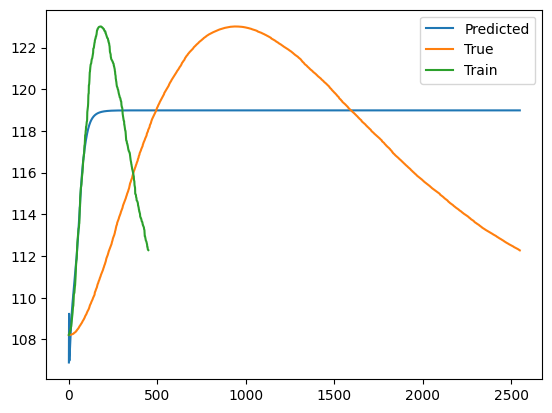

In [74]:
NN.nn.eval()
pred = NN.test(ts_test)

G_pred = pred[0][:,5].reshape(-1,1)
G_true = X_test_arr[:,5].reshape(-1,1)
G_true_2 = X_train_arr[:,5].reshape(-1,1)
ts_test_plot = ts_test.cpu().numpy()
print(ts_test_plot.shape, G_pred.shape)
plt.plot(ts_test_plot, G_pred, label='Predicted')
plt.plot(ts_test_plot, G_true, label='True')
plt.plot(ts_train.cpu().numpy(), G_true_2.cpu().numpy(), label='Train')
plt.legend()
print(G_pred)

1.564036816889645
1.5472147500856661
1.2474305980382763
1.247415539752733
0.010104967942474905
117.560994471807
117.48980875234228
